In [79]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from utils import clean_columns
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier, StackingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, roc_curve, auc
from majority_clf import MajorityVoteClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
import scikitplot as skplt

In [28]:
df = pd.read_csv('https://raw.githubusercontent.com/remijul/dataset/master/Airline%20Passenger%20Satisfaction.csv', sep=';')

In [29]:
df_clean = clean_columns(df).dropna()
X = df_clean.drop(['Satisfaction', 'id'], axis=1)
y = df_clean['Satisfaction']
y = LabelEncoder().fit_transform(y)

In [30]:
X_num = X.select_dtypes(exclude=[object])
X_cat = X.select_dtypes(include=[object])

In [31]:
knn = KNeighborsClassifier()
tree = DecisionTreeClassifier(criterion='log_loss')
gbc = HistGradientBoostingClassifier(loss='log_loss', max_leaf_nodes=None)
rfc = RandomForestClassifier(criterion='log_loss')
xbc = XGBClassifier(objective="binary:logistic")

In [32]:
preparation = ColumnTransformer(transformers=[
    ('tf_cat', OneHotEncoder(sparse_output=False), X_cat.columns),
    ('tf_num', MinMaxScaler(), X_num.columns),
])

pipe_tree = Pipeline(steps=[
    ('preparation', preparation),
    ('model', tree)
])

pipe_knn = Pipeline(steps=[
    ('preparation', preparation),
    ('model', knn)
])

pipe_gbc = Pipeline(steps=[
    ('preparation', preparation),
    ('model', gbc)
])

pipe_rfc = Pipeline(steps=[
    ('preparation', preparation),
    ('model', rfc)
])

pipe_xbc = Pipeline(steps=[
    ('preparation', preparation),
    ('model', xbc)
])


In [ ]:
skf = StratifiedKFold(n_splits=5)

In [33]:
params_knn = {'model__n_neighbors': [4,5,6],
              'model__leaf_size': [20, 30, 40]}
params_gbc = {'model__max_iter': [300, 400, 500]}
params_rfc = {'model__n_estimators': [390, 400, 410]}
params_xbc = {'model__max_depth': [8, 9, 10]}

In [34]:
grid_knn = GridSearchCV(pipe_knn, params_knn, scoring='f1', cv=skf, n_jobs=-1)
grid_gbc = GridSearchCV(pipe_gbc, params_gbc, scoring='f1', cv=skf, n_jobs=-1)
grid_xbc = GridSearchCV(pipe_xbc, params_xbc, scoring='f1', cv=skf, n_jobs=-1)
grid_rfc = GridSearchCV(pipe_rfc, params_rfc, scoring='f1', cv=skf, n_jobs=-1)
grid_list = [pipe_tree, grid_knn, grid_gbc, grid_rfc, grid_xbc]

In [35]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=42, stratify=y)

              precision    recall  f1-score   support

           0       0.93      0.93      0.93     11721
           1       0.94      0.94      0.94     14177

    accuracy                           0.94     25898
   macro avg       0.94      0.94      0.94     25898
weighted avg       0.94      0.94      0.94     25898



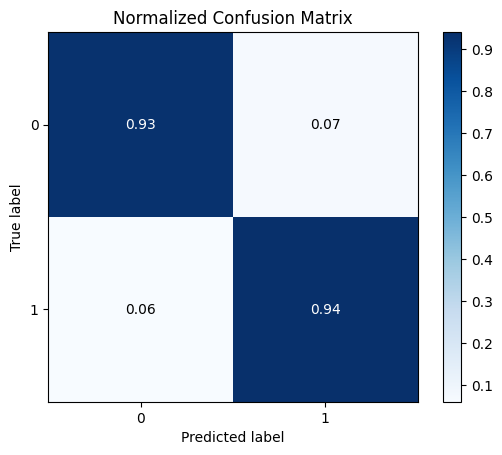

              precision    recall  f1-score   support

           0       0.90      0.94      0.92     11721
           1       0.94      0.91      0.93     14177

    accuracy                           0.92     25898
   macro avg       0.92      0.92      0.92     25898
weighted avg       0.92      0.92      0.92     25898



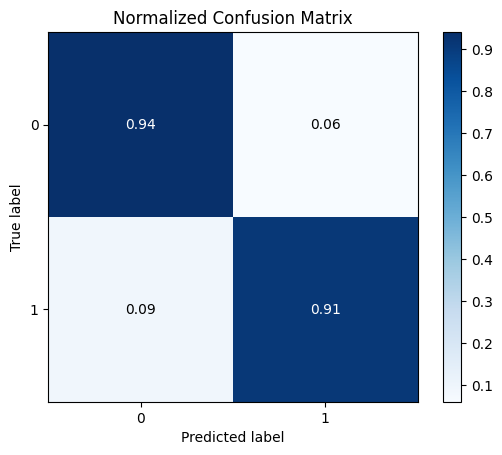

              precision    recall  f1-score   support

           0       0.94      0.96      0.95     11721
           1       0.97      0.95      0.96     14177

    accuracy                           0.96     25898
   macro avg       0.96      0.96      0.96     25898
weighted avg       0.96      0.96      0.96     25898



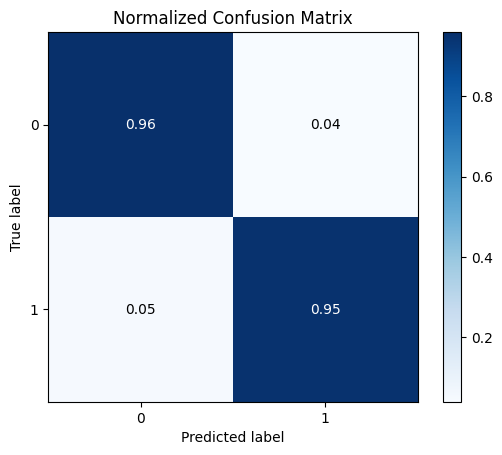

              precision    recall  f1-score   support

           0       0.95      0.96      0.95     11721
           1       0.97      0.95      0.96     14177

    accuracy                           0.96     25898
   macro avg       0.96      0.96      0.96     25898
weighted avg       0.96      0.96      0.96     25898



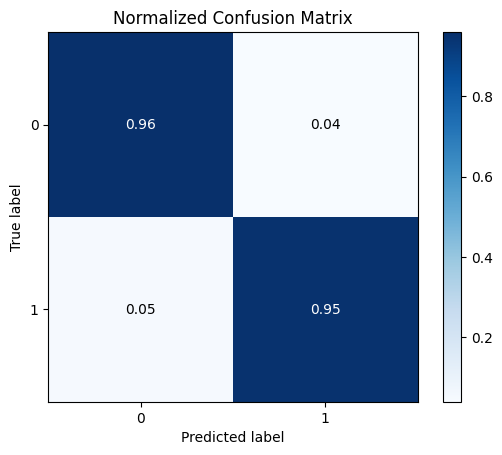

              precision    recall  f1-score   support

           0       0.95      0.96      0.95     11721
           1       0.97      0.95      0.96     14177

    accuracy                           0.96     25898
   macro avg       0.96      0.96      0.96     25898
weighted avg       0.96      0.96      0.96     25898



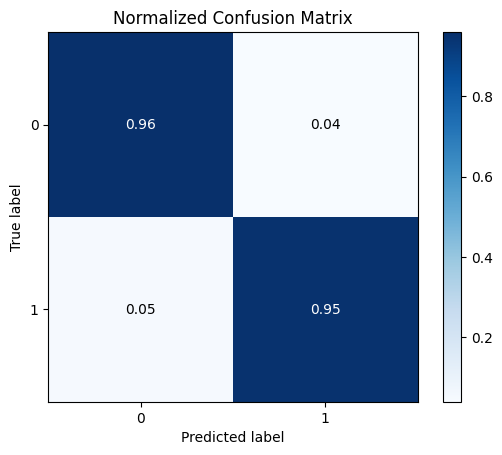

In [36]:
from utils import get_rapport_clf
get_rapport_clf(grid_list, X_train, X_test, y_train, y_test)

              precision    recall  f1-score   support

           0       0.94      0.96      0.95     11721
           1       0.97      0.95      0.96     14177

    accuracy                           0.96     25898
   macro avg       0.95      0.96      0.95     25898
weighted avg       0.96      0.96      0.96     25898



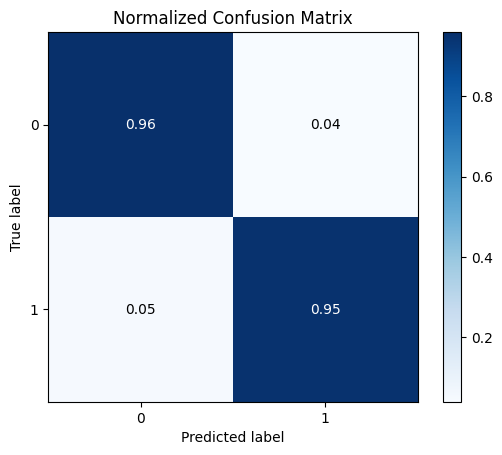

In [37]:
majority_clf = MajorityVoteClassifier([pipe_tree, 
                                       grid_knn.best_estimator_, 
                                       grid_xbc.best_estimator_])
majority_clf.fit(X_train, y_train)
y_pred = majority_clf.predict(X_test)
print(classification_report(y_test, y_pred))
skplt.metrics.plot_confusion_matrix(y_test, y_pred, normalize=True)
plt.show()

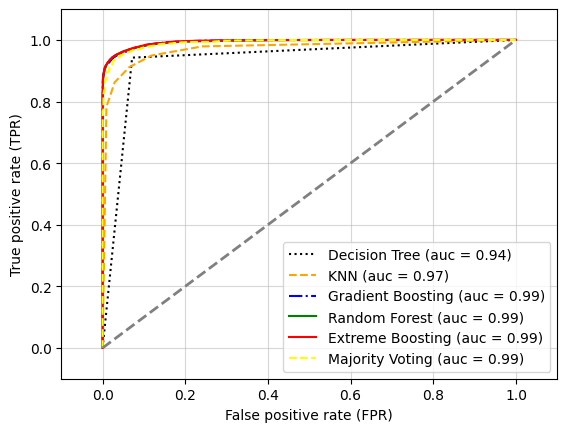

In [38]:
clf_labels = ['Decision Tree', 'KNN', 'Gradient Boosting', 'Random Forest', 'Extreme Boosting', 'Majority Voting']
all_clf = [pipe_tree, 
           grid_knn.best_estimator_, 
           grid_gbc.best_estimator_, 
           grid_rfc.best_estimator_, 
           grid_xbc.best_estimator_,
           majority_clf]

colors = ['black', 'orange', 'blue', 'green', 'red', 'yellow']
linestyles = [':', '--', '-.', '-', 'solid', 'dashed']
for clf, label, clr, ls in zip(all_clf, clf_labels, colors, linestyles):
# assuming the label of the positive class is 1
    y_pred = clf.fit(X_train, y_train).predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_true=y_test, y_score=y_pred)
    roc_auc = auc(x=fpr, y=tpr)
    plt.plot(fpr, tpr, color=clr, linestyle=ls, label='%s (auc = %0.2f)' % (label, roc_auc))
plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', linewidth=2)
plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.grid(alpha=0.5)
plt.xlabel('False positive rate (FPR)')
plt.ylabel('True positive rate (TPR)')
plt.show()

In [65]:
features_imp = {}
for clf, label in zip(all_clf, clf_labels):
    features_imp[label] = {}
    try:
        print(label)
        importances = clf.named_steps['model'].feature_importances_
        names=X.columns
        for value, name in zip(importances, names):
            features_imp[label].update({name: value})
    except:
        print('failed')

Decision Tree
KNN
failed
Gradient Boosting
failed
Random Forest
Extreme Boosting
Majority Voting
failed


In [86]:
df_tree = pd.DataFrame.from_dict(features_imp['Decision Tree'], orient='index').reset_index().rename(columns={'index': 'names', 0: 'values'})
df_rfc = pd.DataFrame.from_dict(features_imp['Random Forest'], orient='index').reset_index().rename(columns={'index': 'names', 0: 'values'})
df_xbc = pd.DataFrame.from_dict(features_imp['Extreme Boosting'], orient='index').reset_index().rename(columns={'index': 'names', 0: 'values'})

<Axes: xlabel='names', ylabel='values'>

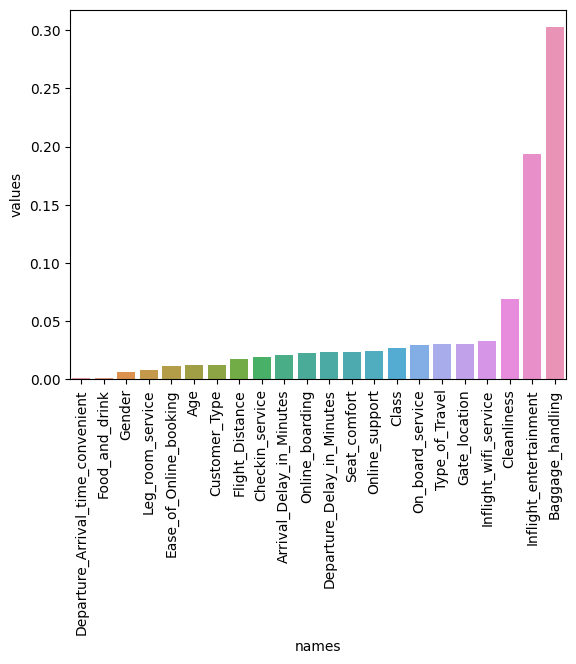

In [85]:
plt.xticks(rotation=90)
sns.barplot(df_tree.sort_values(by='values'), x='names', y='values')

<Axes: xlabel='names', ylabel='values'>

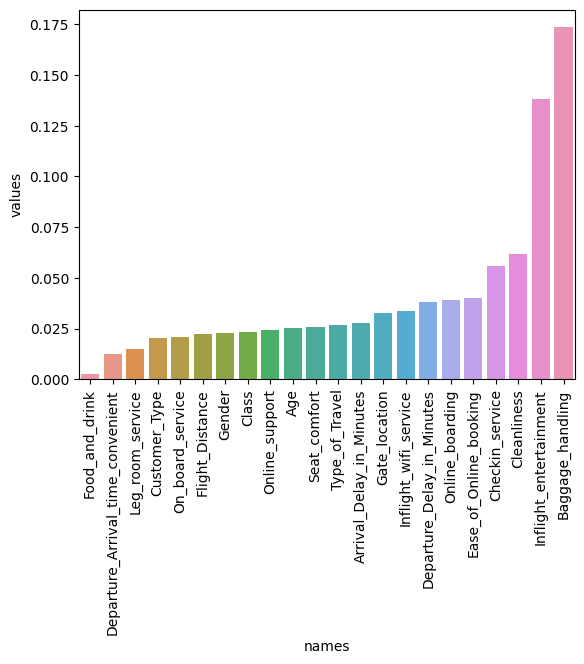

In [87]:
plt.xticks(rotation=90)
sns.barplot(df_rfc.sort_values(by='values'), x='names', y='values')

<Axes: xlabel='names', ylabel='values'>

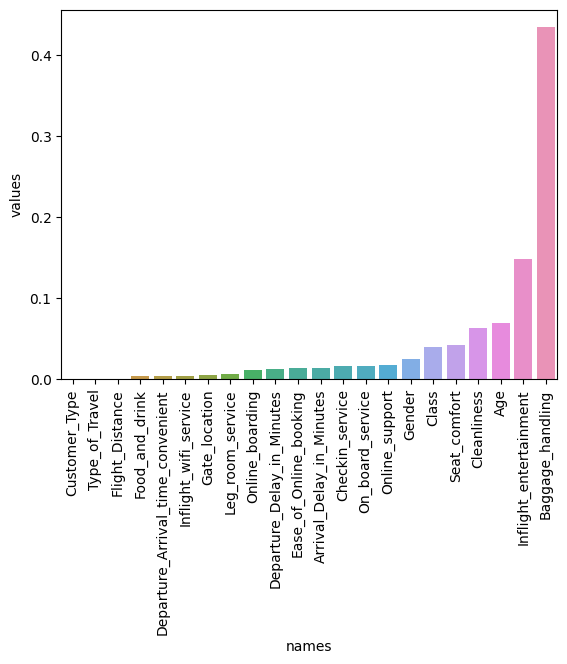

In [88]:
plt.xticks(rotation=90)
sns.barplot(df_xbc.sort_values(by='values'), x='names', y='values')